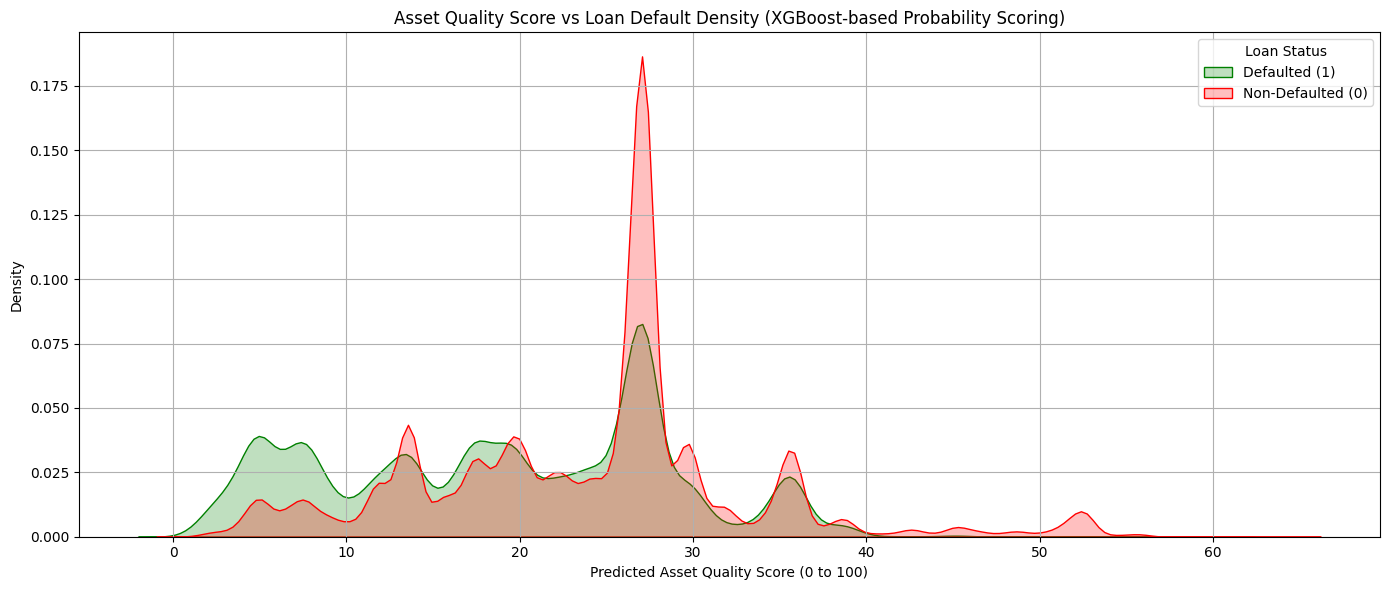

In [ ]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df4 = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\data\\processed\\processed_loan_csv.csv')

# Loading trained XGBoost model
model_xgb = joblib.load('C:\\Users\\Admin\\asset_quality_score\\outputs\\best_xgboost.pkl')
X = df4.drop(columns=['loan_status_binary'])

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#default probabilities from XGBoost
default_probs = model_xgb.predict_proba(X_scaled)[:, 1]

# inverting and scaling to 0–100
df4['predicted_asset_quality_score'] = ((1 - default_probs) * 100).round(2)

# Plotting
plt.figure(figsize=(14, 6))
sns.kdeplot(data=df4[df4['loan_status_binary'] == 1], x='predicted_asset_quality_score', fill=True, color='green', label='Defaulted (1)')
sns.kdeplot(data=df4[df4['loan_status_binary'] == 0], x='predicted_asset_quality_score', fill=True, color='red', label='Non-Defaulted (0)')
plt.title("Asset Quality Score vs Loan Default Density (XGBoost-based Probability Scoring)")
plt.xlabel("Predicted Asset Quality Score (0 to 100)")
plt.ylabel("Density")
plt.legend(title="Loan Status")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:33:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:34:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


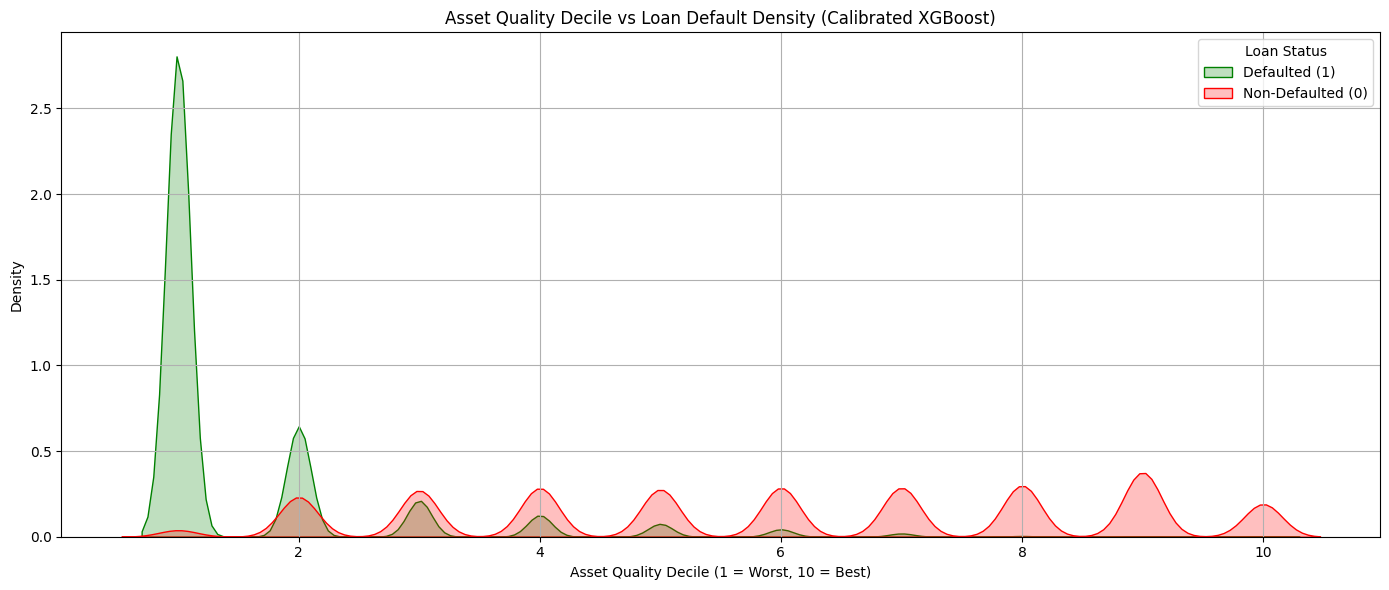

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import joblib

# Loading Dataset
df4 = pd.read_csv('C:\\Users\\Admin\\asset_quality_score\\data\\processed\\processed_loan_csv.csv')
df4 = df4.drop(columns=['predicted_asset_quality_score'], errors='ignore')
X = df4.drop(columns=['loan_status_binary'])
y = df4['loan_status_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#Loading Model
xgb_model = joblib.load('C:\\Users\\Admin\\asset_quality_score\\outputs\\best_xgboost.pkl')

# Calibration using Isotonic Regression
xgb_calibrated = CalibratedClassifierCV(estimator=xgb_model, method='isotonic', cv=3)
xgb_calibrated.fit(X_train, y_train)

#Predict Probabilities and Convert to Decile Scores
calibrated_proba = xgb_calibrated.predict_proba(X)[:, 1] 
df4['raw_asset_score'] = (1 - calibrated_proba) * 100

# Apply decile binning
df4['asset_quality_decile'] = pd.qcut(df4['raw_asset_score'], q=10, labels=False) + 1  # 1 = lowest, 10 = best

# Plotting
plt.figure(figsize=(14, 6))
sns.kdeplot(df4[df4['loan_status_binary'] == 1]['asset_quality_decile'], 
            label='Defaulted (1)', color='green', fill=True)
sns.kdeplot(df4[df4['loan_status_binary'] == 0]['asset_quality_decile'], 
            label='Non-Defaulted (0)', color='red', fill=True)
plt.title('Asset Quality Decile vs Loan Default Density (Calibrated XGBoost)')
plt.xlabel('Asset Quality Decile (1 = Worst, 10 = Best)')
plt.ylabel('Density')
plt.legend(title='Loan Status')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# decile-based asset quality score ranges
decile_ranges = df4.groupby('asset_quality_decile')['raw_asset_score'].agg(['min', 'max', 'mean', 'count']).reset_index()
decile_ranges.columns = ['Asset Quality Decile', 'Min Score', 'Max Score', 'Mean Score', 'Loan Count']

print(decile_ranges)


   Asset Quality Decile  Min Score   Max Score  Mean Score  Loan Count
0                     1   0.000000   50.811332   14.610885      125776
1                     2  50.811384   90.824903   79.570746      125777
2                     3  90.826409   94.978006   93.268675      125848
3                     4  94.978521   96.958891   96.105091      128462
4                     5  96.959723   98.065086   97.506709      123174
5                     6  98.065144   98.986159   98.577639      126033
6                     7  98.986241   99.607258   99.328893      125360
7                     8  99.607560   99.965099   99.854397      130356
8                     9  99.965189   99.980910   99.976266      163882
9                    10  99.980927  100.000000   99.986528       83089


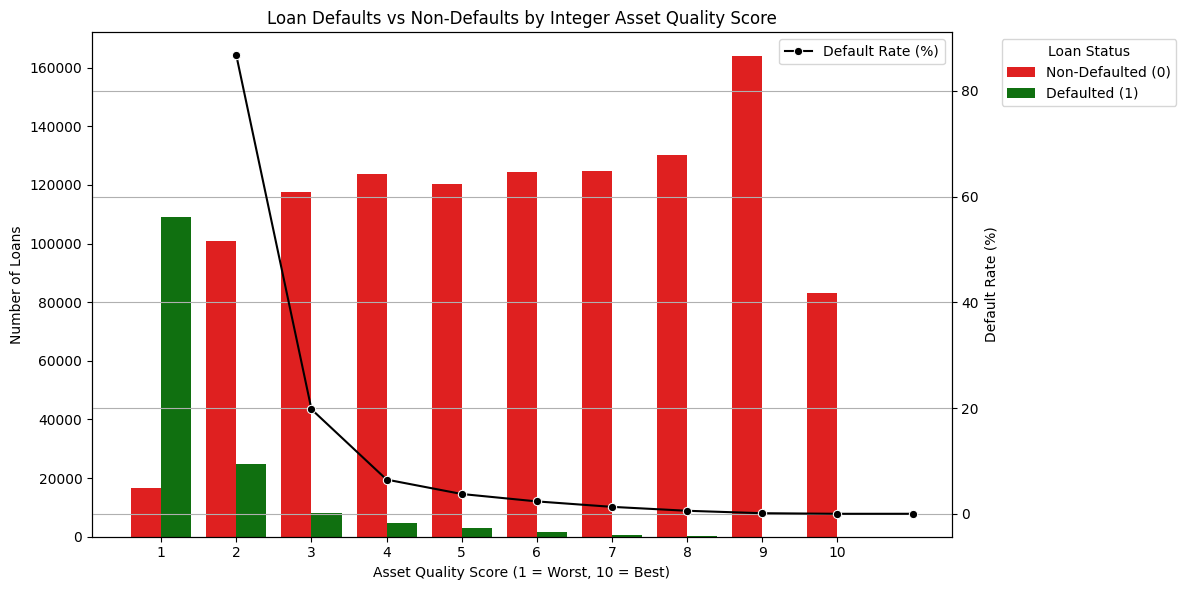

In [ ]:
# integer quality score (1 = worst, 10 = best)
df4['asset_quality_score_int'] = df4['asset_quality_decile'].astype(int)
plt.figure(figsize=(12, 6))

#Count of defaults and non-defaults by integer score
barplot = sns.countplot(
    data=df4,
    x='asset_quality_score_int',
    hue='loan_status_binary',
    palette={0: 'red', 1: 'green'}
)

# default rate per integer score
default_rate = (
    df4.groupby('asset_quality_score_int')['loan_status_binary']
    .mean() * 100 
)

# secondary Y-axis for default rate
ax2 = plt.gca().twinx()
lineplot = sns.lineplot(
    x=default_rate.index,
    y=default_rate.values,
    ax=ax2,
    color='black',
    marker='o',
    label='Default Rate (%)'
)
ax2.set_ylabel('Default Rate (%)')
ax2.legend(loc='upper right')

# labels and title
plt.title('Loan Defaults vs Non-Defaults by Integer Asset Quality Score')
barplot.set_xlabel('Asset Quality Score (1 = Worst, 10 = Best)')
barplot.set_ylabel('Number of Loans')
barplot.legend_.set_title('Loan Status')
barplot.legend_.set_frame_on(True)
barplot.legend_.set_bbox_to_anchor((1.12, 1))
handles, labels = barplot.get_legend_handles_labels()
barplot.legend(
    handles=handles,
    labels=['Non-Defaulted (0)', 'Defaulted (1)'],
    title='Loan Status',
    loc='upper left',
    bbox_to_anchor=(1.05, 1)
)

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# grading logic based on deciles
def assign_grade(decile):
    if decile == 1:
        return 'E - Extremely Risky'
    elif decile == 2:
        return 'D - Risky'
    elif decile in [3, 4]:
        return 'C - Medium Quality'
    elif decile in [5, 6]:
        return 'B - Good Quality'
    else:  # 7–10
        return 'A - Excellent Quality'

# assigning grades
df4['asset_quality_grade'] = df4['asset_quality_decile'].apply(assign_grade)

# saving
final_output_path = 'C:\\Users\\Admin\\asset_quality_score\\data\\processed\\final_asset_quality_scores.csv'
df4.to_csv(final_output_path, index=False)

print(f"Final asset quality scores file saved successfully at:\n{final_output_path}")


✅ Final asset quality scores file saved successfully at:
C:\Users\Admin\asset_quality_score\outputs\final_asset_quality_scores.csv
